In [1]:
import sys
sys.path.append('../../')

import pandas as pd 
from glob import glob
import cv2
from inference import decode_rle_to_mask
from dataset import get_xray_classes
import numpy as np
import matplotlib.pyplot as plt
import utils

/data/ephemeral/conda_envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/ephemeral/conda_envs/torch/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# 시각화를 위한 팔레트를 설정합니다.
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image


def seach_matching_paths(image_name, paths):
    matching_paths = [path for path in paths if image_name in path]
    return matching_paths


def get_preds(image_name, df, classes):
    index = df['image_name'] == image_name
    preds = [[] for _ in range(classes['num_class'])] # 행렬 초기화

    for _, row in df[index].iterrows():
        c, rle = row['class'], row['rle']
        idx = classes['class2idx'][c]
        pred = decode_rle_to_mask(rle, height=2048, width=2048)
        preds[idx] = pred

    preds = np.stack(preds, 0)
    return preds
    

def color_norm(color):
    return [i/255. for i in color]

def plot_gt(anns_path, classes, ax, color=None):
    anns = utils.read_json(anns_path)['annotations']

    for ann in anns:
        class_name = ann["label"]
        if class_name not in classes['class2idx']:
            continue

        class_ind = classes['class2idx'][class_name]
        points = np.array(ann["points"])

        if color is None:
            ax.plot(points[:, 0], points[:, 1], color=color_norm(PALETTE[class_ind]))
        else:
            ax.plot(points[:, 0], points[:, 1], color=color)


In [3]:
file_path = '/data/ephemeral/home/Dongjin/level2-cv-semanticsegmentation-cv-02-lv3/Baseline/Dongjin/transformers_1122/trained_models/openmmlab/upernet-convnext-small_crop_backhand/valid_upernet-convnext-small_crop_backhand_ep_11_vdice_0.9481.csv'
data_dir_path = '/data/ephemeral/home/data'

df = pd.read_csv(file_path)
image_names = df['image_name'].unique()
image_paths = glob(data_dir_path + '/**/*.png', recursive=True)
anns_paths = glob(data_dir_path + '/**/*.json', recursive=True)
classes = get_xray_classes('crop_backhand')

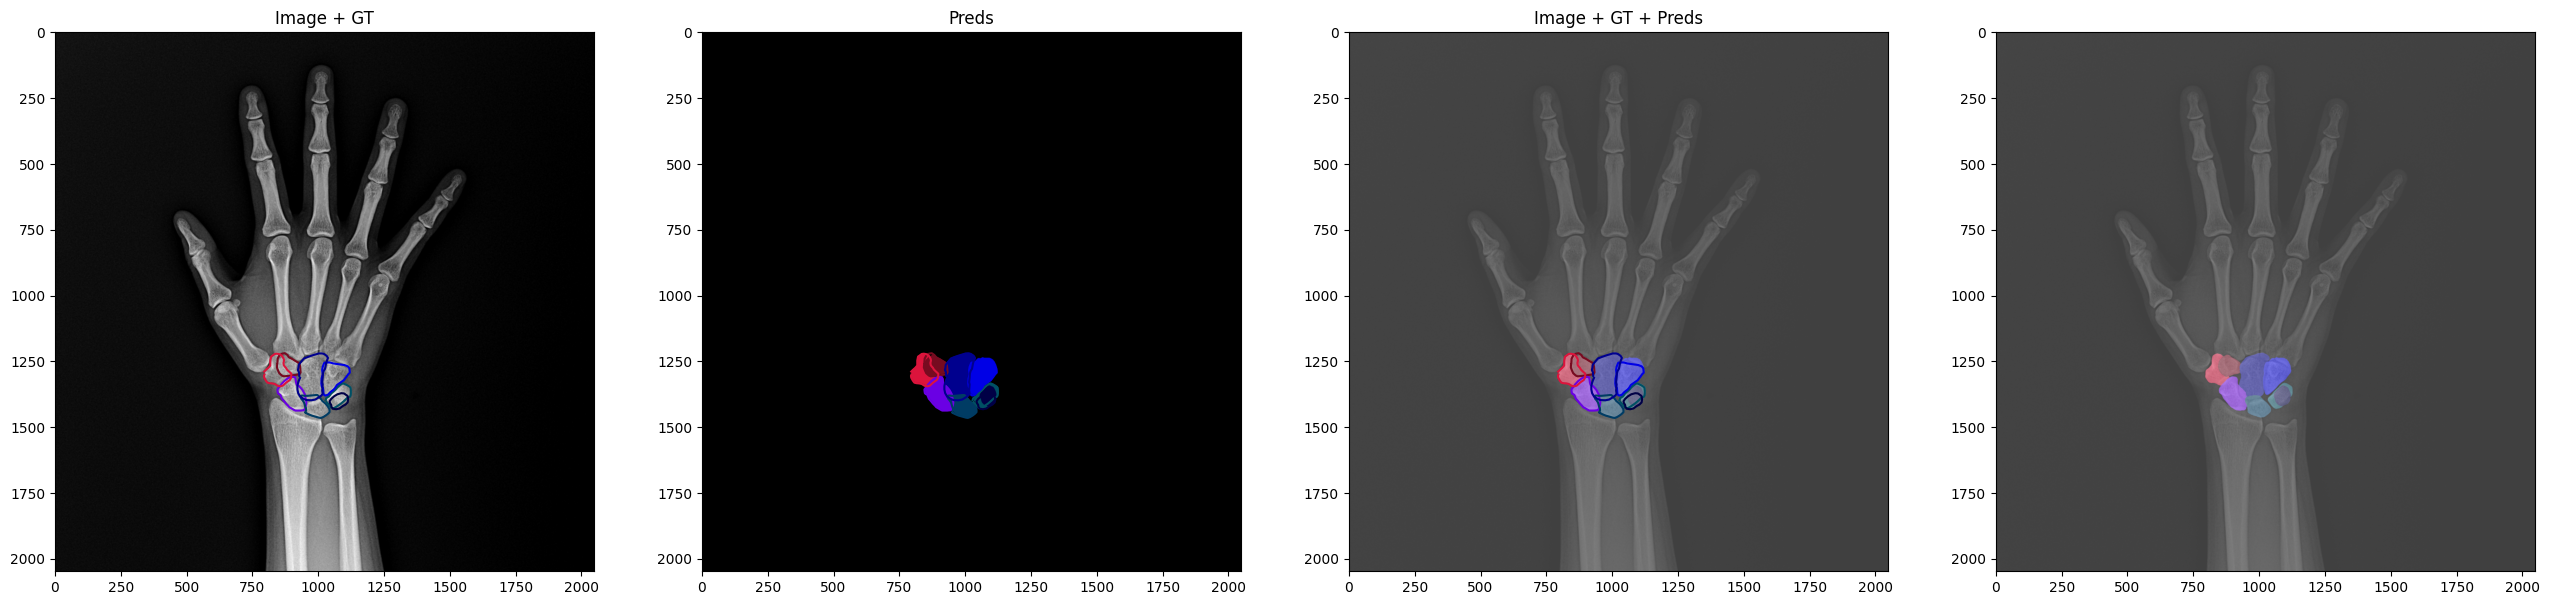

In [ ]:

for image_name in image_names[0:10]:
    target_image_paths = seach_matching_paths(image_name.split('.')[0], image_paths)
    target_anns_paths = seach_matching_paths(image_name.split('.')[0], anns_paths)
    
    # 이름이 매칭되는 이미지 경로가 없거나 여러 가지이면 오류
    if len(target_image_paths) == 0:
        raise(Exception("Fail to find image"))
    elif 1 < len(target_image_paths):
        raise(Exception("Find images more than one"))
    # 이름이 매칭되는 GT가 여러 가지이면 오류
    if 1 < len(target_anns_paths):
        raise(Exception("Find annotations more than one"))
    
    # 이미지 불러오기
    target_image_path = target_image_paths[0] 
    image = cv2.imread(target_image_path)

    # 예측결과 불러오기
    preds = get_preds(image_name, df, classes)

    fig, axes = plt.subplots(1, 4, figsize=(32, 8))

    image_preds = label2rgb(preds)
    image_overlap = image + image_preds

    axes[0].imshow(image)
    axes[1].imshow(image_preds)
    axes[2].imshow(image, alpha=0.5)
    axes[2].imshow(image_preds, alpha=0.5)
    axes[3].imshow(image, alpha=0.5)
    axes[3].imshow(image_preds, alpha=0.5)

    if len(target_anns_paths) == 1:
        target_anns_path = target_anns_paths[0]
        plot_gt(target_anns_path, classes, axes[0])
        plot_gt(target_anns_path, classes, axes[1])
        plot_gt(target_anns_path, classes, axes[2])

    axes[0].set_title("Image + GT")
    axes[1].set_title("Preds")
    axes[2].set_title("Image + GT + Preds")

    plt.show()

    
    

In [8]:
target_anns_paths

['/data/ephemeral/home/data/train/outputs_json/ID021/image1661303652839.json']

In [6]:
"asd".split('.')[0]

'asd'

In [7]:
anns_paths

['/data/ephemeral/home/data/train/outputs_json/ID316/image1664241917976.json',
 '/data/ephemeral/home/data/train/outputs_json/ID316/image1664241944666.json',
 '/data/ephemeral/home/data/train/outputs_json/ID287/image1664156885740.json',
 '/data/ephemeral/home/data/train/outputs_json/ID287/image1664156902082.json',
 '/data/ephemeral/home/data/train/outputs_json/ID018/image1661218881444.json',
 '/data/ephemeral/home/data/train/outputs_json/ID018/image1661218865003.json',
 '/data/ephemeral/home/data/train/outputs_json/ID006/image1661145075929.json',
 '/data/ephemeral/home/data/train/outputs_json/ID006/image1661145103549.json',
 '/data/ephemeral/home/data/train/outputs_json/ID382/image1665453880555.json',
 '/data/ephemeral/home/data/train/outputs_json/ID382/image1665453897981.json',
 '/data/ephemeral/home/data/train/outputs_json/ID320/image1664508892599.json',
 '/data/ephemeral/home/data/train/outputs_json/ID320/image1664508854769.json',
 '/data/ephemeral/home/data/train/outputs_json/ID129